In [18]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [2]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [22]:
model_version = 'v9.0'

In [4]:
with open('data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [5]:
df = pd.read_csv(f"data/processed/spectrometry_photometry.csv")

X = df[spectro_cols + photo_cols + generic_cols]
y = df[target_col]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,))

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_64')(inputs)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_128')(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_256')(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='Dense_64_2')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse', 'mape'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 58)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                3776      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 Dense_256 (Dense)           (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0     

In [9]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.4,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/1000
2932/2932 [==============================] - 24s 8ms/step - loss: 13.7313 - mae: 2.0514 - mse: 10.7093 - mape: 19.4129 - val_loss: 2.5452 - val_mae: 0.5768 - val_mse: 0.4104 - val_mape: 5.3774
Epoch 2/1000
2932/2932 [==============================] - 39s 13ms/step - loss: 4.3600 - mae: 1.3463 - mse: 2.8591 - mape: 12.7185 - val_loss: 1.0414 - val_mae: 0.2112 - val_mse: 0.0773 - val_mape: 2.0142
Epoch 3/1000
2932/2932 [==============================] - 39s 13ms/step - loss: 2.2871 - mae: 1.0320 - mse: 1.6747 - mape: 9.7457 - val_loss: 0.5809 - val_mae: 0.4331 - val_mse: 0.2239 - val_mape: 4.0675
Epoch 4/1000
2932/2932 [==============================] - 40s 14ms/step - loss: 1.1710 - mae: 0.7696 - mse: 0.9402 - mape: 7.2719 - val_loss: 0.2149 - val_mae: 0.2152 - val_mse: 0.0753 - val_mape: 2.0611
Epoch 5/1000
2932/2932 [==============================] - 37s 13ms/step - loss: 0.5694 - mae: 0.5408 - mse: 0.4725 - mape: 5.1188 - val_loss: 0.1565 - val_mae: 0.2277 - val_mse: 0.0

In [23]:
model.save(f'models/{model_version}/spec_photo_model.h5')

In [25]:
save_history(history, model_version)

In [26]:
y_pred_full = model.predict(X_test_scaled)

2094/2094 [==============================] - 3s 1ms/step


In [27]:
plot_metrics(y_test, y_pred_full)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.1475
Root Mean Squared Error (RMSE): 0.2755
R² Score: 0.8243


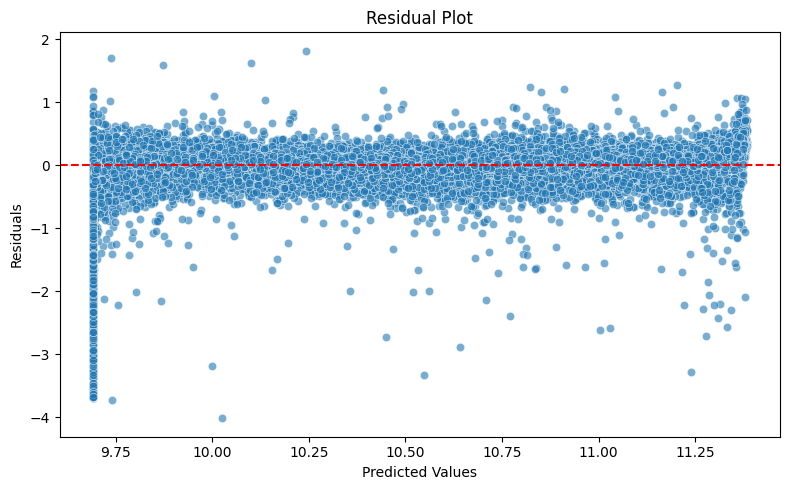

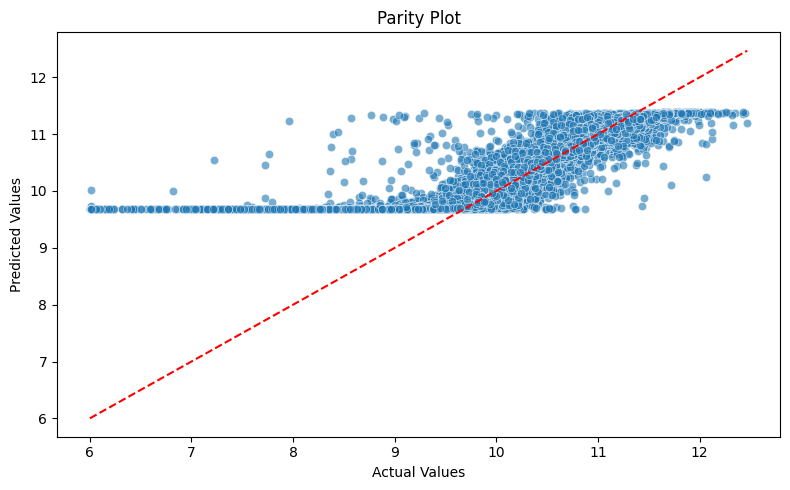

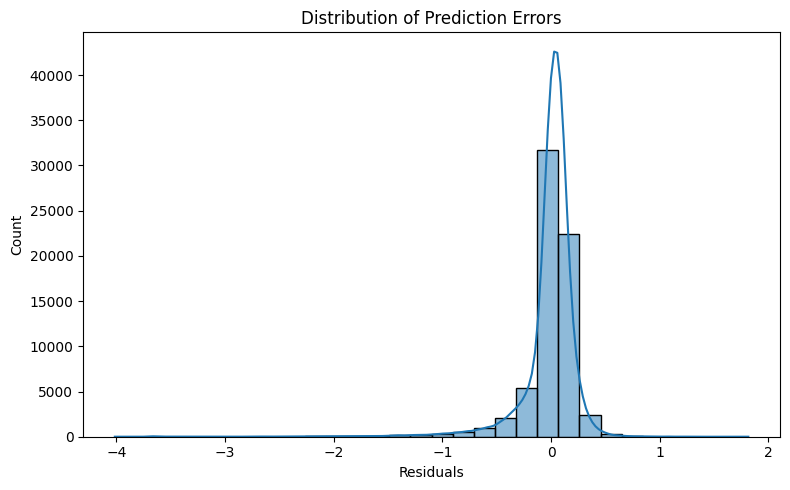

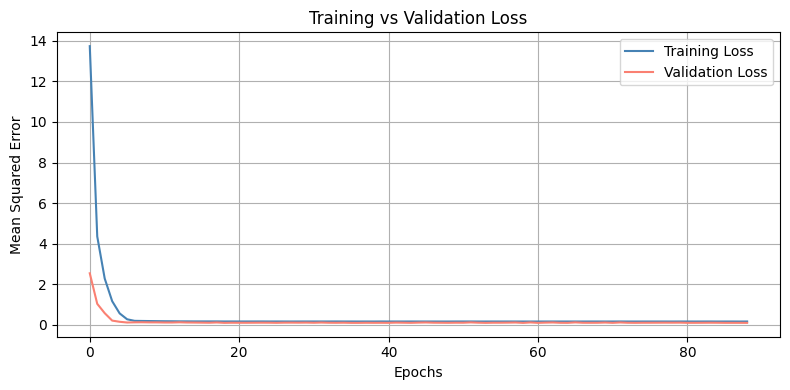

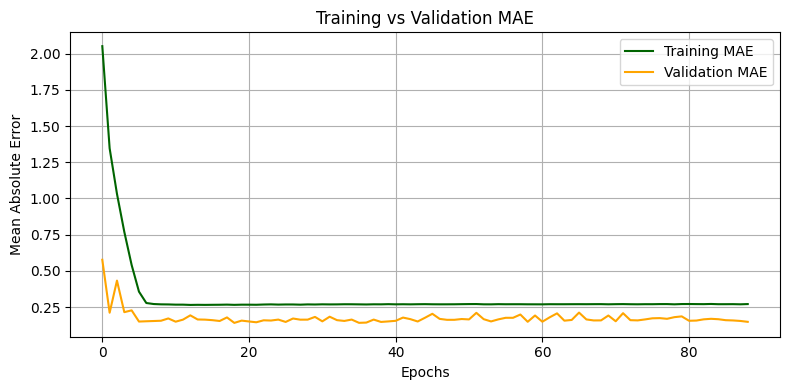

In [28]:
plot_visualizations(history, y_test, y_pred_full)